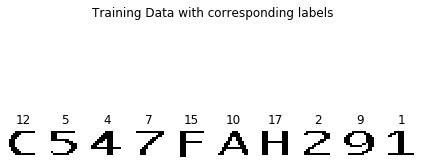

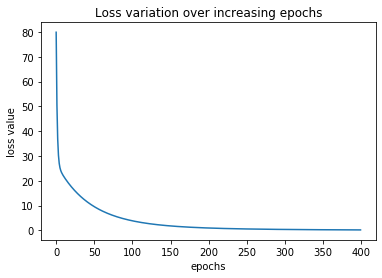

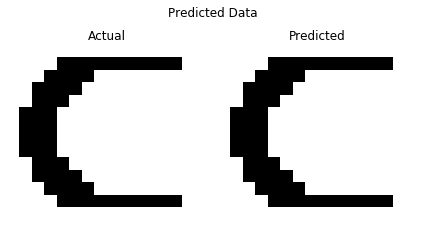

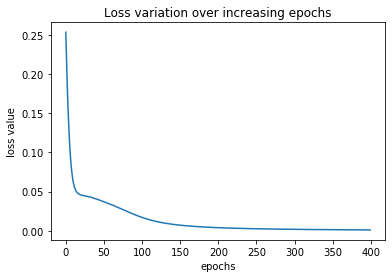

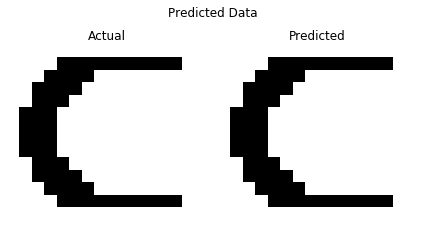

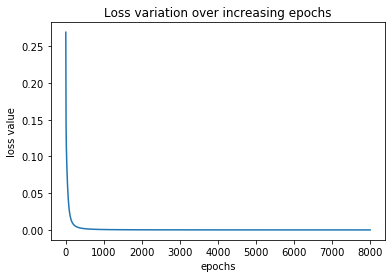

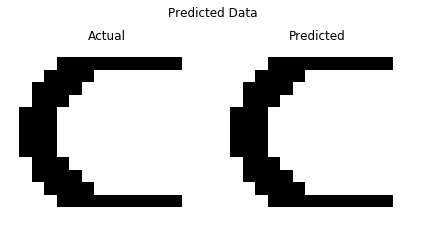

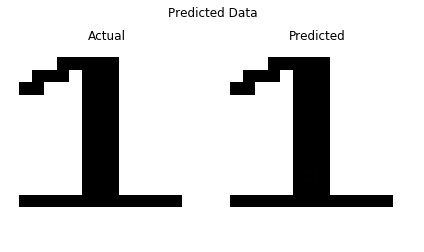

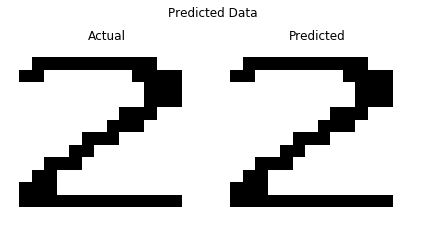

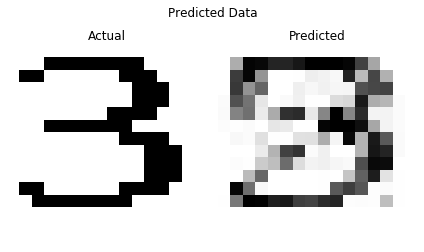

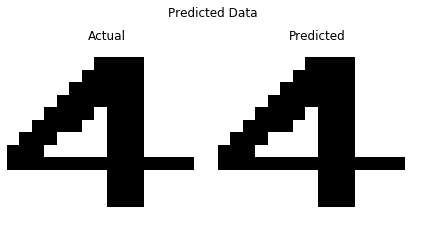

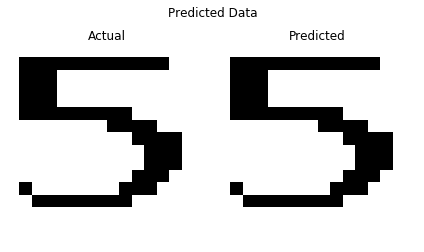

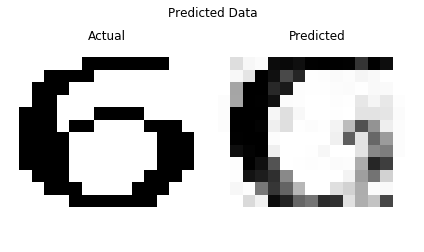

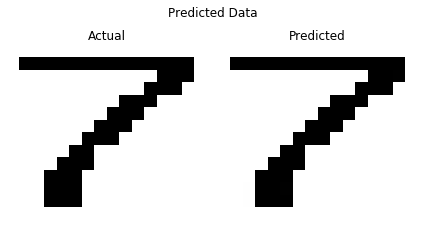

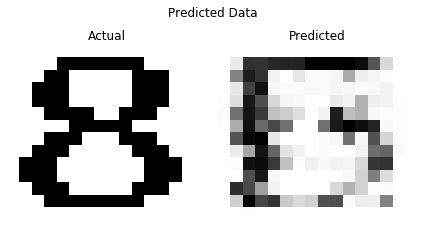

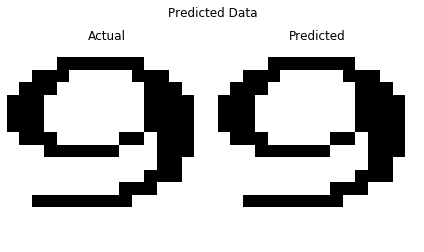

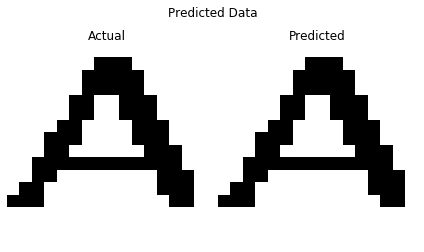

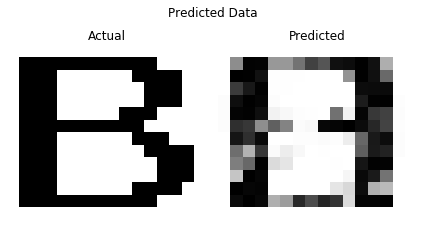

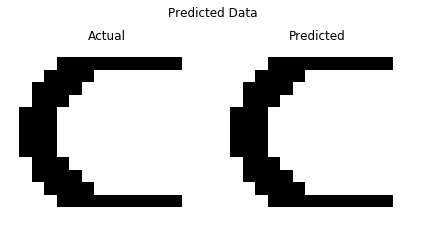

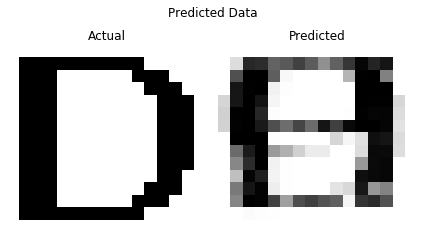

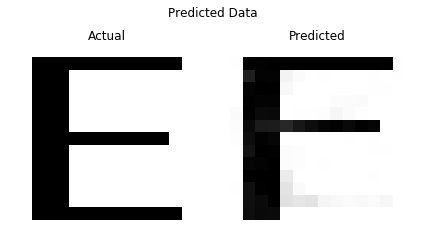

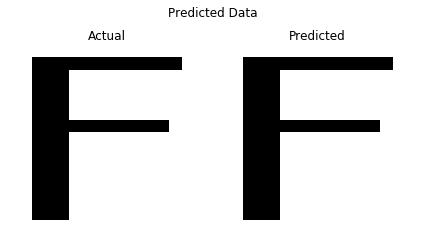

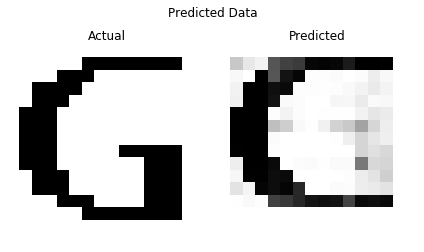

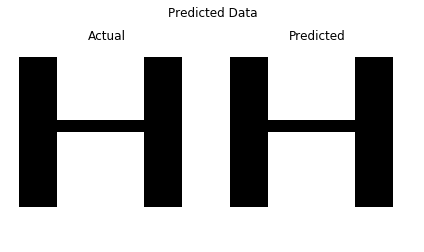

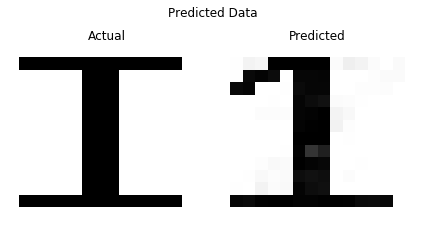

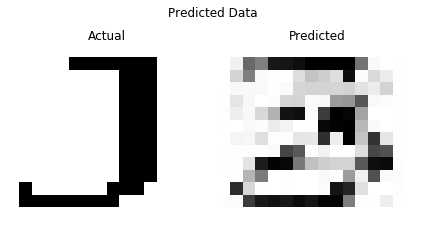

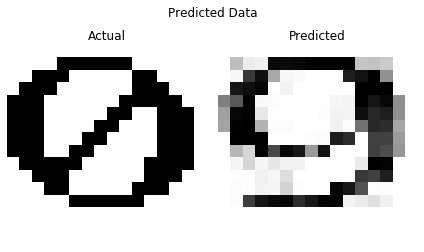

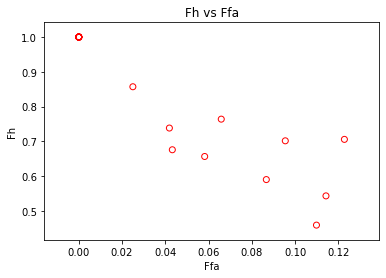

/Library/anaconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/anaconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:117: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


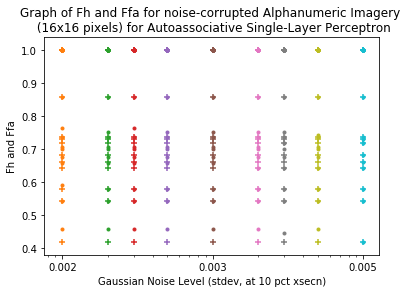

In [2]:
import torch.nn as nn
import torch
import os
from torch.optim import SGD, Adam
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


# Basic Perceptron
class Perceptron(nn.Module):
    def __init__(self, net_inputs, net_output, activation):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(net_inputs, net_output)
        self.act = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        return x

# Noise is Gaussian with 10 percent cross-section
class GaussianNoiseTransform(object):
    def __init__(self, mean=0., std=1., k=25):
        self.std = std
        self.mean = mean
        self.k = k

    def __call__(self, tensor):
        # reshape and flatten
        x_transf = torch.flatten(tensor[0, :], start_dim=0)

        n = x_transf.size(0)
        perm = torch.randperm(n)
        idx = perm[:(n - self.k)]

        noise = torch.randn(x_transf.size())
        # only 10% is noise
        noise[idx] = 0.

        corrupted_image = x_transf + noise * self.std + self.mean
        # renormalize
        corrupted_image -= corrupted_image.min(0, keepdim=True)[0]
        corrupted_image /= corrupted_image.max(0, keepdim=True)[0]

        tensor[0, :] = corrupted_image.reshape(16, 16)

        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class Plotter:
    @staticmethod
    def plot_data(image_datasets, x_train, y_train, kind='train'):
        # plot train data with labels
        R, C = 1, x_train.size(0)
        fig, ax = plt.subplots(R, C)
        fig.suptitle('Training Data with corresponding labels')
        for i, plot_cell in enumerate(ax):
            plot_cell.grid(False)
            plot_cell.axis('off')
            plot_cell.set_title(image_datasets[kind].classes[y_train[i].item()])
            plot_cell.imshow(x_train[i][0], cmap='gray')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_losses(loss_history):
        plt.plot(loss_history)
        plt.title('Loss variation over increasing epochs')
        plt.xlabel('epochs')
        plt.ylabel('loss value')
        plt.show()

    @staticmethod
    def plot_stats(fh, ffa):
        plt.scatter(ffa, fh, facecolors='none', edgecolors='r')
        plt.title('Fh vs Ffa')
        plt.xlabel('Ffa')
        plt.ylabel('Fh')
        plt.show()

    @staticmethod
    def plot_sample(x, y):
        # # plot predicted data with
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Predicted Data')
        ax1.grid(False)
        ax1.axis('off')
        ax1.set_title('Actual')
        ax1.imshow(x, cmap='gray')

        ax2.grid(False)
        ax2.axis('off')
        ax2.set_title('Predicted')
        ax2.imshow(y.detach().numpy(), cmap='gray')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_noise_stats(stats):
        x,y,z = [], [], []
        for sdev, (Fh, Ffa) in stats.items():
            x.append(sdev)
            y.append(Fh)
            z.append(Ffa)

        for xe, ye in zip(x,y):
            plt.scatter([xe]*len(ye), ye, marker='.')
        for xe, ze in zip(x, z):
            plt.scatter([xe] * len(ze), ye, marker='+')

        plt.xticks(x)
        plt.axes().set_xscale('log')
        plt.axes().set_xticklabels(x)
        #plt.legend(labels=x)
        plt.title('Graph of Fh and Ffa for noise-corrupted Alphanumeric Imagery \n (16x16 pixels) for Autoassociative Single-Layer Perceptron')
        plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)')
        plt.ylabel('Fh and Ffa')
        plt.show()

# Manages training life cycle
class TrainingPipeline:
    def __init__(self):
        self.models = [Perceptron(16 * 16, 1, nn.LeakyReLU()), Perceptron(16 * 16, 20, nn.Sigmoid()),
                       Perceptron(16 * 16, 16 * 16, nn.Sigmoid())]
        self.loss = [nn.MSELoss(), nn.MSELoss(), nn.MSELoss()]
        self.optimizer = self.init_optimizer(3)

    def init_optimizer(self, approach):
        self.optimizer = [SGD(self.models[approach - 1].parameters(), lr=0.001),
                          Adam(self.models[approach - 1].parameters(), lr=0.001),
                          Adam(self.models[approach - 1].parameters(), lr=0.001)]

        return self.optimizer

    # Will try 03 approaches as listed in Step 02
    def get_model(self, approach):
        model = self.models[approach - 1]
        loss_fn = self.loss[approach - 1]
        optimizer = self.optimizer[approach - 1]
        return model, loss_fn, optimizer

    def train(self, x, y, model, optimizer, loss_fn, approach, num_epochs=10000):
        loss_history = []
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            pred = model(x)
            if approach != 3:
                pred = pred.squeeze(1)

            loss_value = loss_fn(pred, y)
            loss_value.backward()
            optimizer.step()
            loss_history.append(loss_value)

        return loss_history

    @torch.no_grad()
    def val_loss(self, x, y, model, loss_fn):
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
        return val_loss.item()

    # Create training and validation datasets and initialize data loaders
    def initialize_data(self, data_dir, sdev=0.):
        data_transforms = {
            'train': transforms.Compose([
                transforms.ToTensor()
            ]),
            'val': transforms.Compose([
                transforms.ToTensor()
            ]),
        } if sdev == 0. else {
            'train': transforms.Compose([
                transforms.ToTensor()
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
                GaussianNoiseTransform(std=sdev, k=25)
            ]),
        }

        # Create training and validation datasets
        image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in
                          ['train', 'val']}
        # Create training and validation dataloaders
        image_dataloaders = {
            x: torch.utils.data.DataLoader(image_datasets[x], batch_size=image_datasets[x].__len__(),
                                           shuffle=True if x == 'train' else False)
            for x
            in
            ['train', 'val']}

        return image_datasets, image_dataloaders

    # get labels for Approach 02
    def get_lbl_tensor(self, image_datasets, y, kind='train'):
        mapped_lbls = [int(image_datasets[kind].classes[lookup]) for lookup in y]

        lbls_list = torch.zeros(10, 20)
        for i, indx in enumerate(mapped_lbls):
            lbls_list[i][indx - 1] = 1

        return lbls_list

    def load_all_data(self, image_dataloaders, kind='train'):
        # load
        X_train, Y_train = next(iter(image_dataloaders[kind]))
        # reshape and flatten
        X_train_f = torch.flatten(X_train[:, 0], start_dim=1)

        return X_train, Y_train, X_train_f

    def predict(self, approach_number, model, x, x_test):
        y_pred = model(x)

        if approach_number == 1:
            return x_test[int(round(y_pred.item())) - 1]
        elif approach_number == 2:
            # The index of the output pattern is found by locating the maximum value of y,
            # then finding the indx j of that value
            y = torch.argmax(y_pred)
            return x_test[y.item()]

        elif approach_number == 3:
            return y_pred

    def run_approach(self, approach_number, x_train_f, x_train, x_test, y_train, image_datasets):
        self.init_optimizer(approach_number)
        # setup labeling indexed list
        labels = [torch.FloatTensor([float(image_datasets['train'].classes[lookup]) for lookup in y_train]),
                  self.get_lbl_tensor(image_datasets, y_train),
                  x_train_f
                  ]
        model, loss_func, opt = self.get_model(approach_number)
        loss_history = self.train(x_train_f, labels[approach_number - 1],
                                  model, opt, loss_func, approach_number, 8000 if approach_number == 3 else 400)
        Plotter.plot_losses(loss_history)

        y_test_pred = self.predict(approach_number, model, x_train_f[0], x_test)
        y_pred = y_test_pred.reshape(16, 16)
        Plotter.plot_sample(x_train[0][0], y_pred)

        return model

    def load_pretrained(self, path):
        _models = []
        for approach_num in range(1, 4):
            model, _, _ = self.get_model(approach_num)
            model.load_state_dict(torch.load(f'{path}/model{approach_num}.pth'))
            model.eval()
            _models.append(model)

        return _models

    def render_test_data(self, m, x):
        for i, model in enumerate(m):
            for x_test in x:
                # apply the model
                y_pred = self.predict(i + 1, model, x_test, x)
                if i == 2:
                    Plotter.plot_sample(x_test.reshape(16, 16), y_pred.reshape(16, 16))

    @torch.no_grad()
    def get_fraction_statistics(self, x_test, y_pred):
        a = torch.round(x_test)
        b = torch.round(y_pred)
        diff = abs(a - b)

        blacks = a == 0
        whites = a == 1

        z = torch.logical_and(diff == 0, blacks).sum()
        fh = z.item() / blacks.sum().item()

        z = torch.logical_and(diff == 1, whites).sum()
        ffa = z.item() / whites.sum().item()

        return fh, ffa

    def compute_statistics(self, model, x, approach=3):
        Fh = []
        Ffa = []
        for x_test in x:
            # apply the model
            y_pred = self.predict(approach, model, x_test, x)

            fh, ffa = self.get_fraction_statistics(x_test, y_pred)

            Fh.append(fh)
            Ffa.append(ffa)

        return Fh, Ffa

    def get_noise_stats(self, data_dir, model, sdevs, render=False):
        stats = {}
        for sd in sdevs:
            image_datasets, loaders = self.initialize_data(data_dir, sdev=sd)
            X_test, Y_test, X_test_f = self.load_all_data(loaders, kind='val')

            # plot train data with labels
            if render:
                Plotter.plot_data(image_datasets, X_test, Y_test, kind='val')

            # calculate statistics
            stats[sd] = self.compute_statistics(model, X_test_f)

        return stats

data_dir = "data"

pipeline = TrainingPipeline()
image_datasets, loaders = pipeline.initialize_data(data_dir)
X_train, Y_train, X_train_f = pipeline.load_all_data(loaders)
X_test, Y_test, X_test_f = pipeline.load_all_data(loaders, kind='val')

# plot train data with labels
Plotter.plot_data(image_datasets, X_train, Y_train)

# train model for Approach1
model1 = pipeline.run_approach(1, X_train_f, X_train, X_test_f, Y_train, image_datasets)

# train model for Approach2
model2 = pipeline.run_approach(2, X_train_f, X_train, X_test_f, Y_train, image_datasets)

# train model for Approach3
model3 = pipeline.run_approach(3, X_train_f, X_train, X_test_f, Y_train, image_datasets)

# decide which model is better
models = [model1, model2, model3]
pipeline.render_test_data(models, X_test_f)
#
# Model3 seems to be the best
approach = 3
model = models[approach - 1]

#calculate statistics
Fh, Ffa = pipeline.compute_statistics(model,X_test_f)

Plotter.plot_stats(Fh, Ffa)

# corrupt all images with Gaussian noise
sdevs = [0., 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
stats = pipeline.get_noise_stats(data_dir, model, sdevs)
#pd.DataFrame.from_dict(data=stats).to_csv('data.csv', header=False)

Plotter.plot_noise_stats(stats)
